In [1]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

In [46]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# Lecture des données
sf_swiss = gpd.read_file("data_input/data_raw/Cantons_G1_20250101_2056.geojson")
sf_geneva = sf_swiss[sf_swiss['KTKZ'] == 'GE'].copy()
sf_schaffhausen = sf_swiss[sf_swiss['KTKZ'] == 'SH'].copy()
uno_gaza_strip = gpd.read_file("data_input/data_processed/uno_gaza_strip_level1.gpkg")

# Calculer les aires
sf_geneva['area_km2'] = sf_geneva.to_crs('EPSG:3857').geometry.area / 1e6
uno_gaza_strip['area_km2'] = uno_gaza_strip.to_crs('EPSG:3857').geometry.area / 1e6

# Fonction de masquage
def mask_raster_by_geometry(raster_path, geometry_gdf):
    with rasterio.open(raster_path) as src:
        if geometry_gdf.crs != src.crs:
            geometry_gdf = geometry_gdf.to_crs(src.crs)
        
        out_image, out_transform = rasterio.mask.mask(
            src, geometry_gdf.geometry, crop=True, nodata=np.nan, filled=True
        )
        return out_image[0], out_transform, src.bounds

# Masquer les rasters
gaza_density_masked, gaza_transform, gaza_bounds = mask_raster_by_geometry(
    "data_input/data_processed/ghs_gaza_strip.tif", 
    uno_gaza_strip
)

geneva_density_masked, geneva_transform, geneva_bounds = mask_raster_by_geometry(
    "data_input/data_processed/ghs_geneva.tif", 
    sf_geneva
)



=== CRÉATION DES VISUALISATIONS FINALES ===
=== Bevölkerungsdichte im Vergleich ===
Dimensions: 450x419
Densité max dans array: 459.37
Pixels dans le territoire: 49854 / 188550
✅ Visualisation créée avec succès!
=== Bevölkerungsdichte im Vergleich ===
Dimensions: 284x425
Densité max dans array: 289.87
Géométrie reprojetée de EPSG:2056 vers EPSG:4326
Pixels dans le territoire: 47387 / 120700
✅ Visualisation créée avec succès!
=== Bevölkerungsdichte im Vergleich ===
Dimensions: 307x566
Densité max dans array: 93.30
Géométrie reprojetée de EPSG:2056 vers EPSG:4326
Pixels dans le territoire: 51491 / 173762
✅ Visualisation créée avec succès!


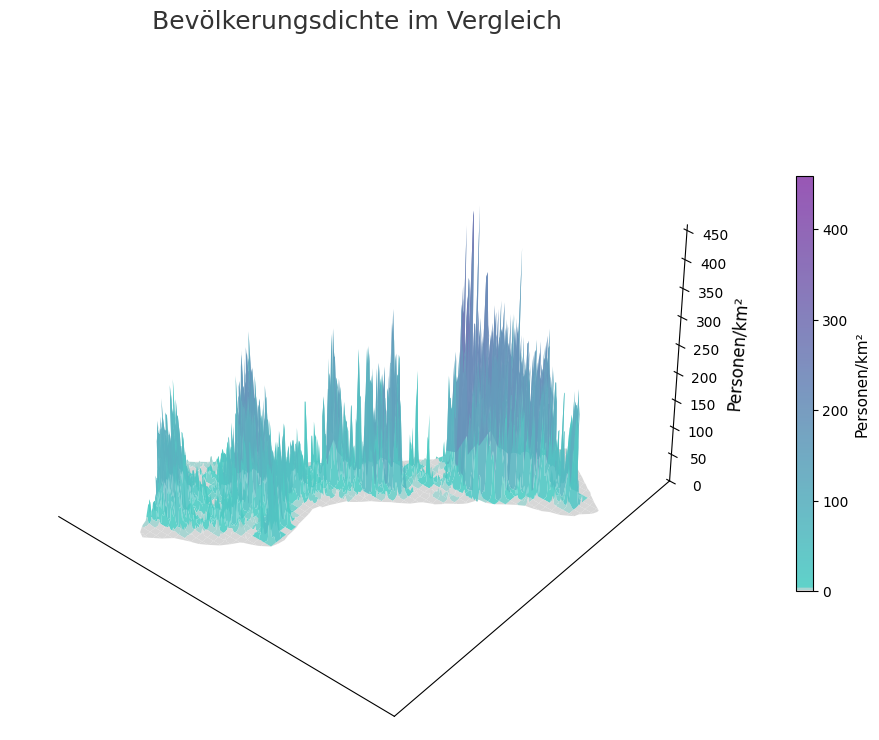

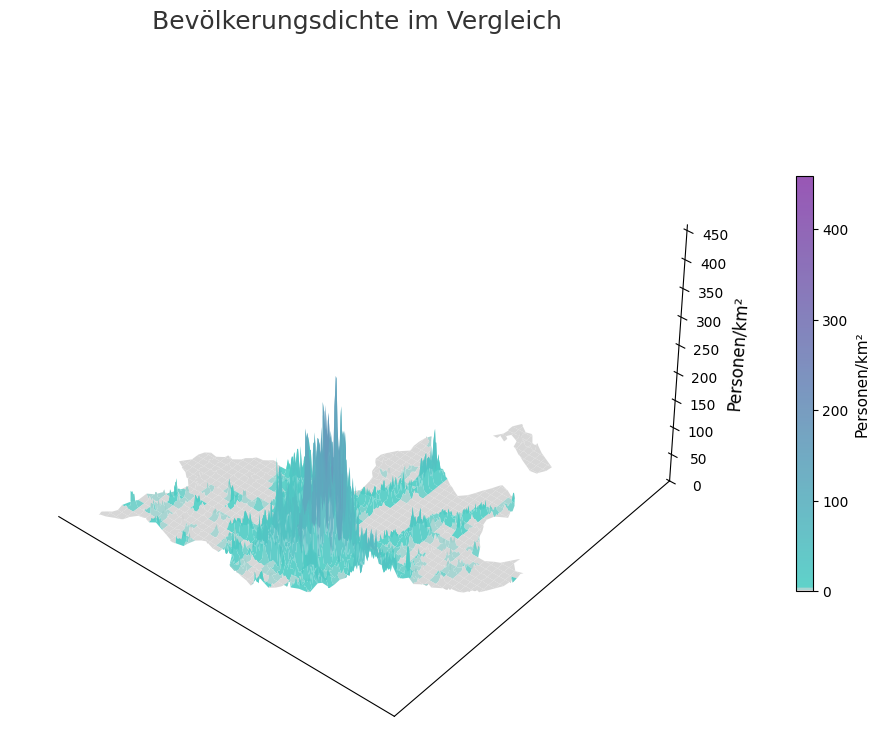

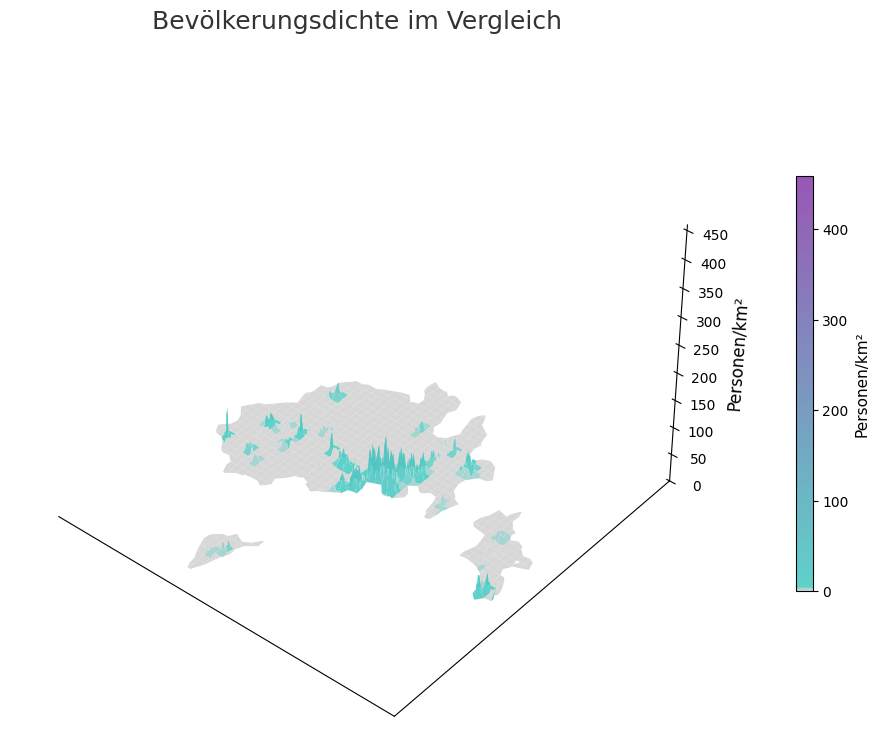


=== EXPORT FINAL ===
Export terminé!


In [50]:
def create_3d_scaled_final_working(density_array, geometry_gdf, transform, title, max_density_global):
    height, width = density_array.shape
    print(f"=== {title} ===")
    print(f"Dimensions: {height}x{width}")
    print(f"Densité max dans array: {np.nanmax(density_array):.2f}")
    
    # Coordonnées
    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    xs = transform[2] + cols * transform[0]
    ys = transform[5] + rows * transform[4]
    
    # IMPORTANT: Reprojeter la géométrie dans le CRS du raster (4326)
    if geometry_gdf.crs.to_string() != 'EPSG:4326':
        geometry_4326 = geometry_gdf.to_crs('EPSG:4326')
        print(f"Géométrie reprojetée de {geometry_gdf.crs} vers EPSG:4326")
    else:
        geometry_4326 = geometry_gdf
    
    # Masque territorial avec la géométrie reprojetée
    from rasterio.features import geometry_mask
    territory_mask = geometry_mask(
        geometry_4326.geometry,  # Utiliser la géométrie reprojetée !
        out_shape=(height, width),
        transform=transform,
        invert=True
    )
    print(f"Pixels dans le territoire: {np.sum(territory_mask)} / {height*width}")
    
    if np.sum(territory_mask) == 0:
        print("❌ ERREUR: Aucun pixel dans le territoire!")
        return None, None
    
    # Créer la visualisation
    fig = plt.figure(figsize=(12, 9), facecolor='white')
    ax = fig.add_subplot(111, projection='3d')
    
    # Préparer les données
    density_display = np.where(territory_mask, density_array, np.nan)
    density_display = np.where(territory_mask & np.isnan(density_array), 0, density_display)
    
    # Palette gris -> bleu rapide -> violet long
    colors = LinearSegmentedColormap.from_list(
        'custom_density', 
        [(0.0, '#D3D3D3'),    # Gris pour 0
         (0.01, '#4ECDC4'),    # Turquoise rapide
         (1.0, '#8E44AD')],   # Violet long
        N=256
    )
    
    # Surface avec échelle globale
    surf = ax.plot_surface(xs, ys, density_display, 
                          cmap=colors, alpha=0.9,
                          linewidth=0, antialiased=True,
                          vmin=0, vmax=max_density_global)
    
    # Échelle Z commune
    ax.set_zlim(0, max_density_global)
    
    # Style
    ax.set_title(title, fontsize=18, color='#333333')
    ax.set_zlabel('Personen/km²', fontsize=12)
    ax.view_init(elev=40, azim=-50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    
    # Nettoyer
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('white')
    ax.yaxis.pane.set_edgecolor('white')
    ax.zaxis.pane.set_edgecolor('white')
    
    # Colorbar
    cbar = plt.colorbar(surf, ax=ax, shrink=0.6, aspect=25, pad=0.1)
    cbar.set_label('Personen/km²', fontsize=11)
    
    print(f"✅ Visualisation créée avec succès!")
    return fig, ax

# Créer les visualisations avec les données corrigées
print("\n=== CRÉATION DES VISUALISATIONS FINALES ===")

fig_gaza_final, ax_gaza_final = create_3d_scaled_final_working(
    gaza_density_masked_fixed, uno_gaza_strip, gaza_transform_fixed,
    "Bevölkerungsdichte im Vergleich", max_global_fixed
)

fig_geneva_final, ax_geneva_final = create_3d_scaled_final_working(
    geneva_density_masked_fixed, sf_geneva, geneva_transform_fixed,
    "Bevölkerungsdichte im Vergleich", max_global_fixed
)

fig_schaffhausen_final, ax_schaffhausen_final = create_3d_scaled_final_working(
    schaffhausen_density_masked_fixed, sf_schaffhausen, schaffhausen_transform_fixed,
    "Bevölkerungsdichte im Vergleich", max_global_fixed
)

plt.show()

# Export final
print("\n=== EXPORT FINAL ===")
import os
output_dir = "data_output/visualisation_3d"
os.makedirs(output_dir, exist_ok=True)

if fig_gaza_final:
    fig_gaza_final.savefig(f'{output_dir}/gaza_density_3d.svg', format='svg', bbox_inches='tight', facecolor='white', dpi=150)
if fig_geneva_final:
    fig_geneva_final.savefig(f'{output_dir}/geneva_density_3d.svg', format='svg', bbox_inches='tight', facecolor='white', dpi=150)
if fig_schaffhausen_final:
    fig_schaffhausen_final.savefig(f'{output_dir}/schaffhausen_density_3d.svg', format='svg', bbox_inches='tight', facecolor='white', dpi=150)

print("Export terminé!")